In [ ]:
# Let’s say you are trying to use a noisy, blurred, low resolution, heavily quantized video feed to estimate the x,y position of a ball.  The primary objective is to estimate the position of the ball as accurately as possible, and as quickly as possible!

# Here is what we know:
#     The field of view of the camera is dark (pixel intensity 0), except for a single ball with uniform brightness (pixel intensity 7) 
#     The ball is exactly 10 pixels in diameter, and has perfectly elastic collisions will the four “walls” bounding the square field of view of the camera
#     There are no external forces acting on the ball (no gravity, no air resistance)
#     The camera's CCD has 101x101 pixels, each with 3-bit intensity resolution [0,7] (greyscale)
#     The camera’s CCD is noisy. Each pixel has noise ~unif(0,5).  This noise is uncorrelated from pixel to pixel, and frame to frame.
#     The ball’s initial position is pixel [0,0] but its initial velocity vector is unknown. The maximum velocity is 7.5 pixels per frame.

# Here are the deliverables:
#     Python simulation of this system. Please comment your code thoroughly, as it will be reviewed in detail.  If you use any open source code, please include citations.
#     A dozen slides containing:
#         Block diagram depicting your simulation structure
#         Why you chose the algorithms you did (what else did you consider?)
#         Plot of estimation accuracy vs frame count (does it converge? Any residual “steady state” error in the long run? Does performance depend on initial condition?)
#         Some analytical justification for the simulation results you are seeing (did simulation agree with analytical? If so, why? If not, why not?)
#         Estimate of total processing resources required to run your system in real time (MAC operations/frame)
#         What would you do differently in your approach if you had more time?
#         What did you find most challenging about this project

In [1]:
# Imports (Run once)
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import pdb # For debugging
import cairo 
import math

Populating the interactive namespace from numpy and matplotlib


In [30]:
# This function adds uniformly distributed noise to each frame and quantizes it
def add_noise(x, lim_low=0.0, lim_high=5.0, bitdepth=3,rs=np.random.RandomState(seed=42)):
    
    b = rs.uniform(low=lim_low, high=lim_high, size=x.shape) + x # Add uniform noise
    print(b)
    adu = b.astype(np.int) # Convert to discrete numbers
    print(adu)
    max_adu = np.int(2**bitdepth - 1)
    adu[adu>max_adu] = max_adu # Models pixel saturation
    print(adu)
    
    return adu

In [29]:
num_pixels = 101
vel = [random.uniform(0.1,7.5) for i in range(2)] # generate a vector with a random x and y velocity
pos = [0,0] # initial position
num_frames = 100
z = np.linspace(0,num_frames, num=num_frames)

[[0.51764706 2.63529412 3.         ... 0.         0.         0.        ]
 [2.68235294 3.         3.         ... 0.         0.         0.        ]
 [3.         3.         3.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[0.96708298 5.27140903 7.87505758 ... 0.24150183 2.70666481 2.17034345]
 [3.62362957 6.56374764 3.43938351 ... 3.40995795 4.86079988 4.86138478]
 [5.40246252 6.29202032 3.77894606 ... 2.74440854 3.43715306 1.83134727]
 ...
 [4.6576225  2.27227356 3.07070698 ... 2.20595892 2.68819032 1.2995577 ]
 [3.27772901 4.57496818 0.90393459 ... 2.54771358 3.45538412 3.83297343]
 [4.14244946 2.98185881 4.41109631 ... 4.95431545 1.74727417 2.01684431]]
[[0 5 7 ... 0 2 2]
 [3 6 3 ... 3 4 4]
 [5 6 3 ... 2 3 1]
 ...
 [4 2 3 ... 2 2 1]
 [3 4 0 ... 2 3 3]
 [4 2 4 ... 

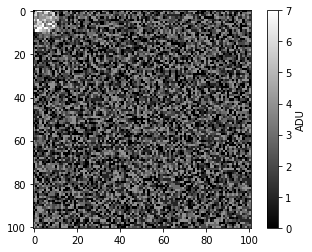

In [40]:
fig, ax = plt.subplots(nrows=1, ncols=1)
# pdb.set_trace()
base_img = np.zeros((num_pixels, num_pixels,4), dtype=np.uint8) # Should be black, 101x101 pixel
surface = cairo.ImageSurface.create_for_data(
    base_img, cairo.FORMAT_ARGB32, num_pixels, num_pixels)
cr = cairo.Context(surface)
cr.set_source_rgb(1.0,1.0,1.0)
cr.paint()
# pdb.set_trace()
cr.arc(5, 5, 5, 0, 2*math.pi)
cr.set_source_rgb(0.0,0.0,0.0)
cr.stroke_preserve()
cr.fill()
# pdb.set_trace()
# plt.imshow(base_img[:,:,0],cmap='gray')
circ_img = base_img[:,:,0]
circ_img = (1 - (circ_img/circ_img.max())) * 3.0 # Convert to 3 bits
print(circ_img)
# pdb.set_trace()
adu = add_noise(circ_img)
img = ax.imshow(adu,cmap='gray')
cb  = plt.colorbar(img)
cb.set_label('ADU')

In [ ]:
def __init__():
    img.set_data(np.zeros((num_pixels,num_pixels)))
    return img

In [ ]:
def animate(frame):
    